In [1]:
# https://www.tensorflow.org/tutorials/load_data/images
# https://keras.io/api/preprocessing/image/
# conda install -n assignment_2 ipykernel --update-deps --force-reinstall
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf

import matplotlib.pyplot as plt

In [3]:
print(tf.__version__)

2.10.0


In [16]:
# Loading images

batch_size = 32
img_height = 150
img_width = 200

train_val_split = 0.2
val_test_split = 0.5

print("Data distribution:")
print(f"Training: {(1 - train_val_split):.2%}")
print(f"validation: {(train_val_split * (1-val_test_split)):.2%}")
print(f"Test: {(train_val_split * val_test_split):.2%}")

train_ds = tf.keras.utils.image_dataset_from_directory(
  "images",
  validation_split=train_val_split,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  "images",
  validation_split=train_val_split,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

test_batches = int(int(val_ds.cardinality()) * val_test_split)
test_ds = val_ds.take(test_batches)
print(f"Test samples: {test_ds.cardinality() * batch_size}")
val_ds = val_ds.skip(test_batches)
print(f"Validation samples: {val_ds.cardinality() * batch_size}")

class_names = train_ds.class_names
print(class_names)


Data distribution:
Training: 80.00%
validation: 10.00%
Test: 10.00%
Found 10015 files belonging to 7 classes.
Using 8012 files for training.
Found 10015 files belonging to 7 classes.
Using 2003 files for validation.
Test samples: 992
Validation samples: 1024
['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


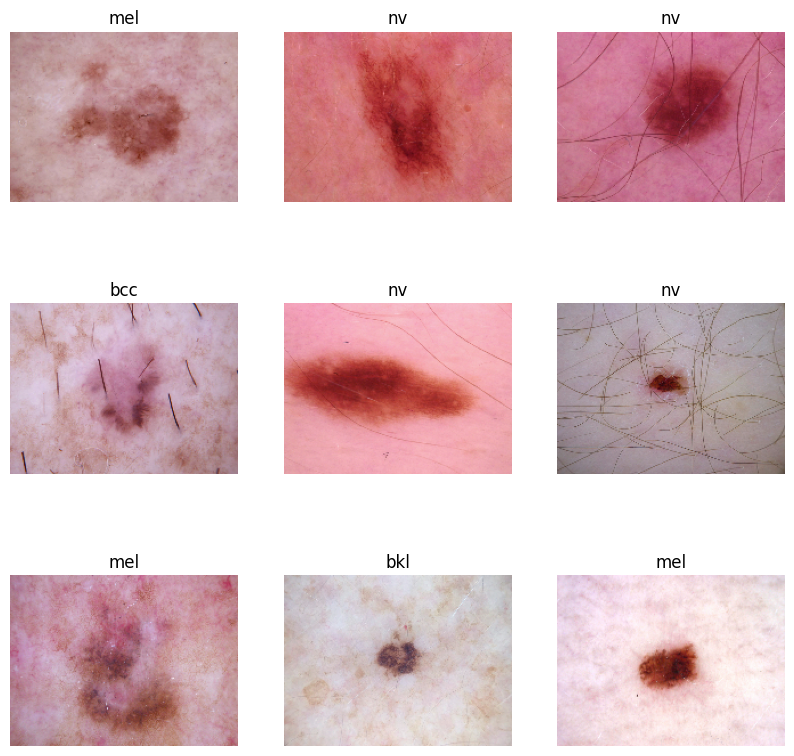

In [17]:
# Visualize data
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [18]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 150, 200, 3)
(32,)


In [19]:
# AUGMENTATION
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

In [20]:
# Normalization
normalization_layer = tf.keras.layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
normalized_val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.006786318 0.8442378


In [21]:
# Training a model
num_classes = 7

model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [27]:
num_classes = 7

model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32, 11, activation='relu'),
  tf.keras.layers.Conv2D(32, 11, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 5, activation='relu'),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='relu'),
  tf.keras.layers.Softmax()
])

In [60]:
# Google Net - https://production-media.paperswithcode.com/methods/Screen_Shot_2020-06-22_at_3.28.59_PM.png
num_classes = 7

def create_inception_module(prev_layer):
    conv1 = tf.keras.layers.Conv2D(128, 1, activation='relu', strides=(1, 1), padding="same")(prev_layer)
    
    conv2 = tf.keras.layers.Conv2D(64, 1, activation='relu', strides=(1, 1), padding="same")(prev_layer)
    conv3 = tf.keras.layers.Conv2D(192, 3, activation='relu', strides=(1, 1), padding="same")(conv2)
    
    conv4 = tf.keras.layers.Conv2D(64, 1, activation='relu', strides=(1, 1), padding="same")(prev_layer)
    conv5 = tf.keras.layers.Conv2D(96, 5, activation='relu', strides=(1, 1), padding="same")(conv4)
    
    max_pool1 = tf.keras.layers.MaxPooling2D((3,3), strides = (1, 1), padding = "same")(prev_layer)
    conv6 = tf.keras.layers.Conv2D(64, 1, activation='relu', strides=(1, 1), padding="same")(max_pool1)
    
    concat = tf.keras.layers.Concatenate(axis=3)([conv1, conv3, conv5, conv6])
    
    return concat


input = tf.keras.Input((150, 200, 3))

conv1 = tf.keras.layers.Conv2D(64, 7, activation='relu', strides=(2, 2), padding="same")(input)
max_pool1 = tf.keras.layers.MaxPooling2D((3,3), strides = (2, 2), padding = "same")(conv1)
conv2 = tf.keras.layers.Conv2D(192, 3, activation='relu', strides=(1, 1), padding="same")(max_pool1)
max_pool2 = tf.keras.layers.MaxPooling2D((3,3), strides = (2, 2), padding = "same")(conv2)

inception1 = create_inception_module(max_pool2)
inception2 = create_inception_module(inception1)
inception3 = create_inception_module(inception2)

avg_pool = tf.keras.layers.AveragePooling2D((7,7), strides=(1,1))(inception3)
flatten = tf.keras.layers.Flatten()(avg_pool)
dense = tf.keras.layers.Dense(num_classes, activation='relu')(flatten)
softmax = tf.keras.layers.Softmax()(dense)

model = tf.keras.Model(inputs=[input], outputs=[softmax])

Conv 1: (None, 75, 100, 64)
Max Pool 1: (None, 38, 50, 64)
Conv 2: (None, 38, 50, 192)
Max Pool 2: (None, 19, 25, 192)
Inception Module
Conv 1: (None, 19, 25, 128)
Conv 2: (None, 19, 25, 64)
Conv 3: (None, 19, 25, 192)
Conv 4: (None, 19, 25, 64)
Conv 5: (None, 19, 25, 192)
Max Pool 1: (None, 19, 25, 192)
Conv 6: (None, 19, 25, 64)
Concatenate: (None, 19, 25, 480)
Inception Module
Conv 1: (None, 19, 25, 128)
Conv 2: (None, 19, 25, 64)
Conv 3: (None, 19, 25, 192)
Conv 4: (None, 19, 25, 64)
Conv 5: (None, 19, 25, 192)
Max Pool 1: (None, 19, 25, 480)
Conv 6: (None, 19, 25, 64)
Concatenate: (None, 19, 25, 480)
Inception Module
Conv 1: (None, 19, 25, 128)
Conv 2: (None, 19, 25, 64)
Conv 3: (None, 19, 25, 192)
Conv 4: (None, 19, 25, 64)
Conv 5: (None, 19, 25, 192)
Max Pool 1: (None, 19, 25, 480)
Conv 6: (None, 19, 25, 64)
Concatenate: (None, 19, 25, 480)
Avg Pool: (None, 13, 19, 480)
Flatten: (None, 118560)
Dense: (None, 7)
Softmax: (None, 7)


In [51]:
optimizers = [
    'adam',
    'sgd',
    'adadelta',
    'adamax',
    'rmsprop'
]

for optim in optimizers:

    model.compile(
    optimizer=optim,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])
    
    print(f"Using {optim} optimizer")
    model.fit(
        normalized_ds,
        validation_data=normalized_val_ds,
        epochs=3
    )

Using adam optimizer
Epoch 1/3
251/251 [==============================] - 23s 89ms/step - loss: 0.7266 - accuracy: 0.7293 - val_loss: 0.7438 - val_accuracy: 0.7112
Epoch 2/3
251/251 [==============================] - 23s 88ms/step - loss: 0.7101 - accuracy: 0.7341 - val_loss: 0.7862 - val_accuracy: 0.7082
Epoch 3/3
251/251 [==============================] - 22s 87ms/step - loss: 0.7068 - accuracy: 0.7340 - val_loss: 0.7629 - val_accuracy: 0.7092
Using sgd optimizer
Epoch 1/3
251/251 [==============================] - 23s 87ms/step - loss: 0.7494 - accuracy: 0.7237 - val_loss: 0.7677 - val_accuracy: 0.7221
Epoch 2/3
251/251 [==============================] - 22s 88ms/step - loss: 0.7226 - accuracy: 0.7310 - val_loss: 0.8809 - val_accuracy: 0.6874
Epoch 3/3
251/251 [==============================] - 22s 85ms/step - loss: 0.7051 - accuracy: 0.7365 - val_loss: 0.7411 - val_accuracy: 0.7181
Using adadelta optimizer
Epoch 1/3
251/251 [==============================] - 23s 90ms/step - loss: 0

In [52]:
loss_funcs = [
    tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    tf.keras.losses.CategoricalHinge(),
    tf.keras.losses.MeanSquaredError()
]

for loss_func in loss_funcs:

    model.compile(
    optimizer='adam',
    loss=loss_func,
    metrics=['accuracy'])
    
    print(f"Using {loss_func.name} loss function")
    model.fit(
        normalized_ds,
        validation_data=normalized_val_ds,
        epochs=3
    )

Using <keras.losses.SparseCategoricalCrossentropy object at 0x0000021FB8CAE7F0> loss function
Epoch 1/3
251/251 [==============================] - 24s 90ms/step - loss: 0.6667 - accuracy: 0.7466 - val_loss: 0.7283 - val_accuracy: 0.7478
Epoch 2/3
251/251 [==============================] - 24s 92ms/step - loss: 0.6529 - accuracy: 0.7542 - val_loss: 0.7218 - val_accuracy: 0.7280
Epoch 3/3
251/251 [==============================] - 22s 87ms/step - loss: 0.6468 - accuracy: 0.7505 - val_loss: 0.7404 - val_accuracy: 0.7280
Using <keras.losses.CategoricalHinge object at 0x0000021FBEE5CB80> loss function
Epoch 1/3
251/251 [==============================] - 24s 92ms/step - loss: 0.9048 - accuracy: 0.1234 - val_loss: 0.0469 - val_accuracy: 0.0524
Epoch 2/3
251/251 [==============================] - 24s 93ms/step - loss: 0.0461 - accuracy: 0.0783 - val_loss: 0.0408 - val_accuracy: 0.0653
Epoch 3/3
251/251 [==============================] - 25s 96ms/step - loss: 0.0440 - accuracy: 0.0754 - val_los

In [61]:
model.compile(
  optimizer='adadelta',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
  metrics=['accuracy'])

In [62]:
model.fit(
  normalized_ds,
  validation_data=normalized_val_ds,
  epochs=3
)

Epoch 1/3
251/251 [==============================] - 536s 2s/step - loss: 1.5492 - accuracy: 0.6634 - val_loss: 1.2790 - val_accuracy: 0.6489
Epoch 2/3
  1/251 [..............................] - ETA: 12:02 - loss: 1.3291 - accuracy: 0.6250

KeyboardInterrupt: 